## **Image Anomaly detection**

In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashikraveendran","key":"6fa88eb0e7b76e1f213dc6622c92edad"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d thtuan/mvtecad-mvtec-anomaly-detection


Dataset URL: https://www.kaggle.com/datasets/thtuan/mvtecad-mvtec-anomaly-detection
License(s): unknown


In [7]:
!unzip mvtecad-mvtec-anomaly-detection.zip -d mvtec_ad

Streaming output truncated to the last 5000 lines.
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/149.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/150.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/151.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/152.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/153.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/154.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/155.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/156.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/157.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/158.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/159.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/good/160.png  
  inflating: mvtec_ad/mvtec_anomaly_detection/carpet/train/go

In [3]:
! pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
pip install pillow==9.5.0

  Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.4 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print "Tesla T4"

True
Tesla T4


In [2]:
import os
import sys
import time
import random
import copy
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.backends.cudnn as cudnn
from easydict import EasyDict
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
from MLSP.code.dataloader import get_dataloader
from MLSP.code.timm.models.vision_transformer import *
from MLSP.code.timm import create_model
from MLSP.code.mean_std import obj_stats_384


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **Parameters**

In [5]:
args = EasyDict({
    'n_gpu':1,
    'image_size':384,
    'patch_size':16,
    'device':'cuda',
    'batch_size':8,
    'num_workers':16,
    'epochs':20,
    'lr':2e-4,
    'wd':1e-5,
    'obj':'carpet',
    'val_ratio':0.4,
    'save_dir':'./LG_ES_Transformer/AnoViT/result',
    'dataset_path':'./mvtec_ad/mvtec_anomaly_detection',
    'model':'vit',
    'amp':True,
    'seed':42,
    'beta1':0.5,
    'beta2':0.999
})

### **CNN Decoder**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder_r(nn.Module):
    def __init__(self, args):
        super(Decoder_r, self).__init__()
        self.args = args
        self.dec_block1 = nn.Sequential(
            nn.ConvTranspose2d(768, 256, (3, 3)),
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        )

        self.dec_block2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, (3, 3)),
            nn.InstanceNorm2d(128),
            nn.ReLU(True)
        )

        self.dec_block3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (3, 3)),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        )

        self.dec_block4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, (3, 3), stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(True)
        )

        self.dec_block5 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, (3, 3), stride=2, padding=1),
            nn.InstanceNorm2d(16),
            nn.ReLU(True)
        )

        self.dec_block6 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, (3, 3), stride=2, padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU(True)
        )

        self.up = nn.UpsamplingBilinear2d((args.image_size,args.image_size)) # fixed output size
        self.tanh = nn.Tanh()

    def forward(self,x):
        out = x[:,1:,:]
        out = out.transpose(1,2)
        out = out.reshape(x.shape[0], -1, self.args.image_size//self.args.patch_size, self.args.image_size//self.args.patch_size)
        out = self.dec_block1(out)
        out = self.dec_block2(out)
        out = self.dec_block3(out)
        out = self.dec_block4(out)
        out = self.dec_block5(out)
        out = self.dec_block6(out)
        out = self.up(out)
        out = self.tanh(out)
        return out


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## **Importing ViT decoder from timm**

In [7]:
device = args.device
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

scaler = amp.GradScaler()

model = create_model('vit_base_patch16_384', pretrained=True)
decmodel = nn.Sequential(model, Decoder_r(args))
decmodel.to(device)

<ipython-input-7-1e11cff5b8c8>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Bl

## **Load Dataset**

In [8]:
train_loader, val_loader, test_loader = get_dataloader(args)

## **Training**

In [9]:
optimizer = torch.optim.Adam(
        params=decmodel.parameters(),
        lr=args.lr,
        betas=(args.beta1, args.beta2))

In [10]:
def train(args, scaler, model, epoch, train_loader, optimizer):
    model.train()
    MSE = nn.MSELoss()

    for (x, _, _) in tqdm(train_loader):
        x = x.to(args.device)
        optimizer.zero_grad()
        if args.amp:
            with amp.autocast():
                x_hat = model(x)
                loss = MSE(x, x_hat)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    print('Train Epoch: {} | MSE Loss: {:.6f}'.format(epoch, loss))

def val(args, model, epoch, val_loader):
    model.eval()
    MSE = nn.MSELoss()

    for (x, _, _) in tqdm(val_loader):
        x = x.to(args.device)
        with torch.no_grad():
            x_hat = model(x)
            loss = MSE(x, x_hat)

    return loss, model

In [11]:
for epoch in range(1, args.epochs + 1):
    train(args, scaler, decmodel, epoch, train_loader, optimizer)
    val_loss, save_model = val(args, decmodel, epoch, val_loader)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-10-52533487481e>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Epoch: 1 | MSE Loss: 1.065674


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Train Epoch: 2 | MSE Loss: 1.022155


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Train Epoch: 3 | MSE Loss: 1.042942


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Train Epoch: 4 | MSE Loss: 1.014608


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Train Epoch: 5 | MSE Loss: 1.014469


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Train Epoch: 6 | MSE Loss: 1.006935


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 7 | MSE Loss: 1.003347


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train Epoch: 8 | MSE Loss: 1.008449


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 9 | MSE Loss: 1.033643


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train Epoch: 10 | MSE Loss: 1.008446


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 11 | MSE Loss: 0.994707


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Train Epoch: 12 | MSE Loss: 1.003722


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Train Epoch: 13 | MSE Loss: 1.012749


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Train Epoch: 14 | MSE Loss: 1.022462


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Train Epoch: 15 | MSE Loss: 0.977656


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 16 | MSE Loss: 0.985495


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 17 | MSE Loss: 1.012044


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train Epoch: 18 | MSE Loss: 1.016853


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Train Epoch: 19 | MSE Loss: 0.962372


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Train Epoch: 20 | MSE Loss: 1.011554


100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


In [18]:
torch.save(save_model.state_dict(), 'model.pt')

## **Test**

In [19]:
decmodel = nn.Sequential(model, Decoder_r(args))
decmodel.load_state_dict(torch.load('model.pt'), strict=False)
decmodel.to(device)

Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Bl

In [22]:
train_loader, valid_loader, test_loader = get_dataloader(args)

### **Evaluation**

In [12]:
def test(model, test_loader, device=torch.device('cuda:0')):
    model.eval()
    MSE = nn.MSELoss(reduction='none')
    det_scores, seg_scores = [],[]
    test_imgs = []
    gt_list = []
    gt_mask_list = []
    recon_imgs = []

    det_sig, seg_sig = 15,6
    for (x, label, mask) in tqdm(test_loader):
        mask = mask.squeeze(0)
        test_imgs.extend(x.cpu().numpy())
        gt_list.extend(label.cpu().numpy())
        gt_mask_list.extend(mask.cpu().numpy())
        score = 0
        with torch.no_grad():
            x = x.to(device)
            x_hat = model(x)

            mse = MSE(x,x_hat)
            score = mse

        score = score.cpu().numpy()
        score = score.mean(1)

        det_score, seg_score = copy.deepcopy(score), copy.deepcopy(score)

        for i in range(det_score.shape[0]):
            det_score[i] = gaussian_filter(det_score[i], sigma=det_sig)
        det_scores.extend(det_score)

        for i in range(seg_score.shape[0]):
            seg_score[i] = gaussian_filter(seg_score[i], sigma=seg_sig)
        seg_scores.extend(seg_score)

        recon_imgs.extend(x_hat.cpu().numpy())
    return det_scores, seg_scores, test_imgs, recon_imgs, gt_list, gt_mask_list

In [13]:
det_scores, seg_scores, test_imgs, recon_imgs, gt_list, gt_mask_list = test(decmodel, test_loader, device)

seg_scores = np.asarray(seg_scores)
max_anomaly_score = seg_scores.max()
min_anomaly_score = seg_scores.min()
seg_scores = (seg_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)

gt_mask = np.asarray(gt_mask_list)
gt_mask = gt_mask.astype('int')
per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), seg_scores.flatten())
print('pixel ROCAUC: %.2f' % (per_pixel_rocauc))

100%|██████████| 117/117 [00:16<00:00,  7.01it/s]


pixel ROCAUC: 0.65


In [17]:
def plot_anomaly_results(real_imgs, recon_imgs, seg_scores, gt_masks, index=0, obj_name='carpet'):
    def to_img(img, mean, std):
        if img.ndim == 3 and img.shape[0] == 3:  # (C, H, W)
            # De-normalize
            for c in range(3):
                img[c] = img[c] * std[c] + mean[c]
            img = np.transpose(img, (1, 2, 0))  # to (H, W, C)
        else:
            img = np.squeeze(img)

        # Clip for visualization
        img = np.clip(img, 0, 1) if img.dtype.kind == 'f' else np.clip(img, 0, 255)
        return img

    mean, std = obj_stats_384(obj_name)

    real = to_img(real_imgs[index], mean, std)
    recon = to_img(recon_imgs[index], mean, std)
    anomaly = np.squeeze(seg_scores[index])
    gt = np.squeeze(gt_masks[index])

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title('real')
    plt.imshow(real)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('reconstruction')
    plt.imshow(recon)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('anomaly score')
    plt.imshow(anomaly, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('ground truth')
    plt.imshow(gt, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


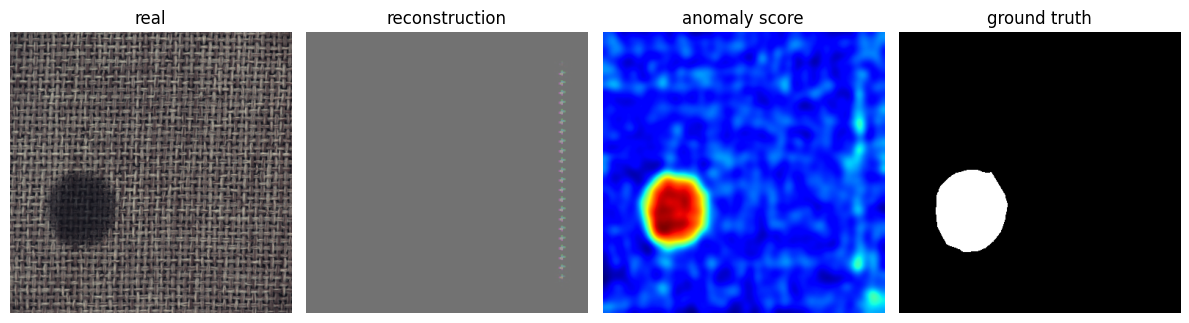

In [18]:
plot_anomaly_results(test_imgs, recon_imgs, seg_scores, gt_mask_list, index=0)